In [1]:
import MDAnalysis as mda

In [2]:
import nglview as nv

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv

import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [5]:
import os
DATA = os.path.join('/home', 'uni', 'capstone', 'EROS_Ub/')
print(DATA)

/home/uni/capstone/EROS_Ub/


In [6]:
mda_universe = mda.Universe(os.path.join(DATA, "2k39.pdb"))

In [7]:
import py3Dmol

In [8]:
from MDAnalysis.analysis import align

In [9]:
def visualize_mda_universe(u, \
    sel_string='not ((resname WAT) or (resname HOH))', 
    style={"cartoon": {'color': 'spectrum'}}):
  """
  Inputs: 
  u : mdanalysis universe
  sel_string : mdanalysis selection string for visible atoms
  style : py3Dmol style
  """
  # The number of frames in the simulation
  number_frames_analysis = len(u.trajectory)
  if number_frames_analysis > 10:
    stride_animation = number_frames_analysis/1 #100 KC
  else:
    stride_animation = 1

  # Deleting previously stored frames as PDBs and removing warnings
  import warnings
  warnings.filterwarnings('ignore')
  !rm [0-9]?.pdb 2> /dev/null
  
    # Helper classes to read and get PDB fields
  class Atom(dict):
    def __init__(self, line):
      self["type"] = line[0:6].strip()
      self["idx"] = line[6:11].strip()
      self["name"] = line[12:16].strip()
      self["resname"] = line[17:20].strip()
      #self["resid"] = int(int(line[22:26]))
      self["resid"] = int(line[22:26])
      #print(type(self["resid"]))
      #print(self["resid"])  
      self["x"] = float(line[30:38])
      self["y"] = float(line[38:46])
      #self["z"] = float(line[46:54])
      self["z"] = float(line[46:54])
      self["sym"] = line[76:78].strip()

    def __str__(self):
      line = list(" " * 80)
      line[0:6] = self["type"].ljust(6)
      line[6:11] = self["idx"].ljust(5)
      line[12:16] = self["name"].ljust(4)
      line[17:20] = self["resname"].ljust(3)
      line[22:26] = str(self["resid"]).ljust(4)
      line[30:38] = str(self["x"]).rjust(8)
      line[38:46] = str(self["y"]).rjust(8)
      line[46:54] = str(self["z"]).rjust(8)
      line[76:78] = self["sym"].rjust(2)
      return "".join(line) + "\n"
          
  class Molecule(list):
    def __init__(self, file):
      for line in file:
        if "ATOM  " in line or "HETATM" in line:
          self.append(Atom(line))
              
      def __str__(self):
        outstr = ""
        for at in self:
          outstr += str(at)
        return outstr

  # Write out frames for animation
  protein = u.select_atoms(sel_string) 
  i = 0
  for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]: 
      if i > -1:
          with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
              W.write(protein)
      i = i + 1
  # Load frames as molecules (py3Dmol let us visualize a single "molecule" per frame)
  molecules = []
  for i in range(int(len(u.trajectory)/int(stride_animation))):
      with open('' + str(i) + '.pdb') as ifile:
          molecules.append(Molecule(ifile))

  models = ""
  for i in range(len(molecules)):
    models += "MODEL " + str(i) + "\n"
    for j,mol in enumerate(molecules[i]):
      models += str(mol)
    models += "ENDMDL\n"

  # Animation
  view = py3Dmol.view(width=800, height=600)
  view.addModelsAsFrames(models)
  for i, at in enumerate(molecules[0]):
      view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", style))

  view.zoomTo()
  view.animate({'loop': "forward", 'reps': 0})
  return view

In [10]:
view = visualize_mda_universe(mda_universe)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
# Set trajectory pointer to first frame as reference
mda_universe.trajectory[0]

# in_memory=True is needed to actually modify the loaded trajectory
# if the trajectory is too big for memory, one can write out the aligned trajectory and reload it into a new universe
alignment = align.AlignTraj(
    mobile=mda_universe, reference=mda_universe, select="protein", in_memory=True
)
alignment.run()

In [12]:
view = visualize_mda_universe(mda_universe)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory[0]
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()
    columns = [selection1, *selection2] if selection2 else [selection1]
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "frame"
    return rmsd_df

In [14]:
rmsd = rmsd_for_atomgroups(mda_universe, "backbone", ["protein"])
rmsd.head()

,backbone,protein
frame,,
0,0.00,0.00
1,3.10,3.68
2,3.45,3.57
3,2.98,3.85
4,0.98,1.76


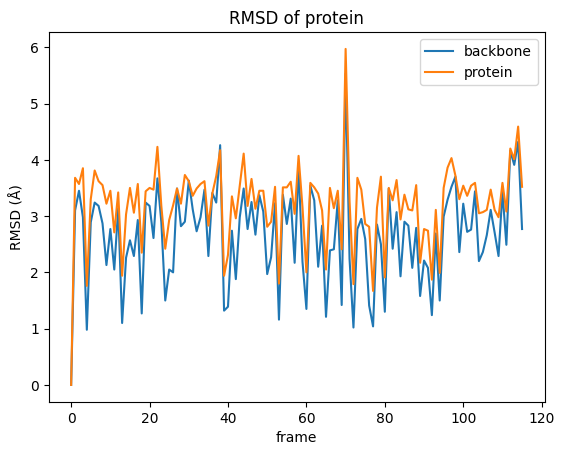

In [15]:
rmsd.plot(title="RMSD of protein")
plt.ylabel("RMSD (Å)");

In [16]:
def RMSD_dist_frames(universe, selection):
    """Calculate the RMSD between all frames in a matrix.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection: str
        Selection string for the atomgroup to be investigated, also used during alignment.

    Returns
    -------
    array: np.ndarray
        Numpy array of RMSD values.
    """
    pairwise_rmsd = diffusionmap.DistanceMatrix(universe, select=selection)
    pairwise_rmsd.run()
    return pairwise_rmsd.dist_matrix

In [17]:
dist_matrix_protein = RMSD_dist_frames(mda_universe, "protein")

In [18]:
# get maximal distance between all frames
max_dist = np.amax(dist_matrix_protein)

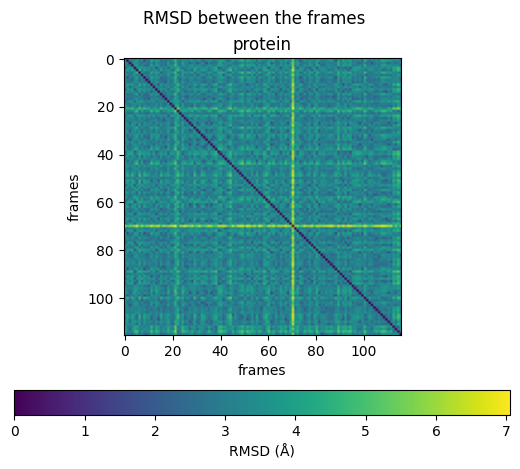

In [19]:
fig, ax = plt.subplots(1,1)
fig.suptitle("RMSD between the frames")

# protein image
img1 = ax.imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax.title.set_text("protein")
ax.set_xlabel("frames")
ax.set_ylabel("frames")


fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)")

In [20]:
protein_residue_id1 = "53"
protein_residue_id2 = "24"
view = visualize_mda_universe(mda_universe, 
  sel_string = f"resid {protein_residue_id1} or (resid {protein_residue_id2})", \
    style = {'stick':{}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Peptide flip motion as distance

In [21]:
protein_atom_name1 = "N"

protein_atom_name2 = "OE1"

In [22]:
atomgroup_protein1 = mda_universe.select_atoms(
    f"resid {protein_residue_id1} and name {protein_atom_name1}")
atomgroup_protein2 = mda_universe.select_atoms(
    f"resid {protein_residue_id2} and name {protein_atom_name2}")

In [23]:
distance = dist(atomgroup_protein1, atomgroup_protein2)
print(
    f"The distance between residues {protein_residue_id1} and {protein_residue_id2} is {distance[2][0]:.2f} Å"
)

The distance between residues 53 and 24 is 5.15 Å


In [24]:
distances = []
for _ in mda_universe.trajectory:
    distance = dist(atomgroup_protein1, atomgroup_protein2)
    distances.append(distance[2][0])

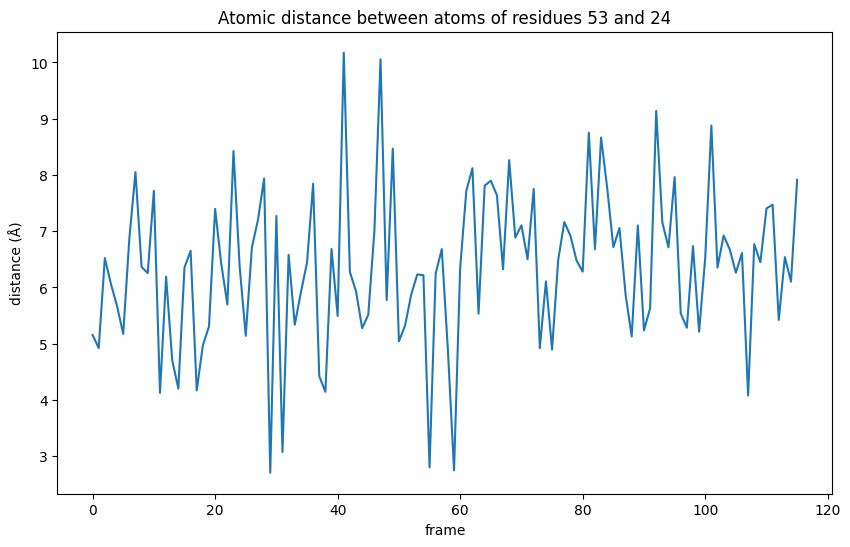

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
#plt.gca().set_ylim(bottom=0)
plt.ylabel("distance (Å)")
plt.xlabel("frame")
plt.title(f"Atomic distance between atoms of residues {protein_residue_id1} and {protein_residue_id2}")
plt.show()

In [26]:
min(distances)

np.float64(2.7054038457445384)

In [27]:
distances[29]

np.float64(2.7054038457445384)

The 30th frame is in the peptide flip "in" conformation

In [28]:
# Select the specific frame you want to write
frame_index = 29  # For example, the 30th frame (index starts at 0)
mda_universe.trajectory[frame_index]  # Set the trajectory to the desired frame

# Select the atoms you want to write (e.g., the entire universe or a subset)
selected_atoms = mda_universe.select_atoms("all")  # Adjust the selection as needed

# Write the selected frame to a PDB file
# with mda.Writer("2K39_30.pdb", selected_atoms.n_atoms) as writer:
#     writer.write(selected_atoms)

print("Frame written to 2K39_30.pdb")

Frame written to 2K39_30.pdb


In [29]:
# python
from MDAnalysis.analysis import align

# Set the trajectory pointer to the desired reference frame
reference_frame = 29  # For example, the 30th frame (index starts at 0)
universe=mda_universe.trajectory[reference_frame]

DATA2 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster0\\"
DATA3 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster1\\"
DATA4 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster2\\"
DATA5 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster3\\"
DATA6 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster4\\"
DATA7 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster5\\"
DATA8 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster6\\"
DATA9 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster7\\"
DATA10 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster8\\"
DATA11 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster9\\"
DATA12 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster10\\"
DATA13 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster11\\"
DATA14 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster12\\"
DATA15 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster13\\"
DATA16 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster14\\"
DATA17 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster15\\"
DATA18 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster16\\"
DATA19 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster17\\"
DATA20 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster18\\"
DATA21 = r"D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster19\\"
print(DATA21)
sig30scale70c0v1 = mda.Universe(os.path.join(DATA2, "11_47_042.r0_min.pdb"))
sig30scale70c0v2 = mda.Universe(os.path.join(DATA2, "18_47_042.r24_min.pdb"))
sig30scale70c1v1 = mda.Universe(os.path.join(DATA3, "5_47_042.r20_min.pdb"))
sig30scale70c1v2 = mda.Universe(os.path.join(DATA3, "5_47_042.r64_min.pdb"))
sig30scale70c2v1 = mda.Universe(os.path.join(DATA4, "1_47_042.r36_min.pdb"))
sig30scale70c2v2 = mda.Universe(os.path.join(DATA4, "1_47_042.r44_min.pdb"))
sig30scale70c3v1 = mda.Universe(os.path.join(DATA5, "21_47_042.r32_min.pdb"))
sig30scale70c3v2 = mda.Universe(os.path.join(DATA5, "21_47_042.r49_min.pdb"))
sig30scale70c4v1 = mda.Universe(os.path.join(DATA6, "3_47_042.r29_min.pdb"))
sig30scale70c4v2 = mda.Universe(os.path.join(DATA6, "3_47_042.r51_min.pdb"))
sig30scale70c5v1 = mda.Universe(os.path.join(DATA7, "6_47_042.r24_min.pdb"))
sig30scale70c5v2 = mda.Universe(os.path.join(DATA7, "6_47_042.r54_min.pdb"))
sig30scale70c6v1 = mda.Universe(os.path.join(DATA8, "5_47_042.r4_min.pdb"))
sig30scale70c6v2 = mda.Universe(os.path.join(DATA8, "8_47_042.r40_min.pdb"))
sig30scale70c7v1 = mda.Universe(os.path.join(DATA9, "37_47_042.r12_min.pdb"))
sig30scale70c7v2 = mda.Universe(os.path.join(DATA9, "45_47_042.r24_min.pdb"))
sig30scale70c8v1 = mda.Universe(os.path.join(DATA10, "8_47_042.r29_min.pdb"))
sig30scale70c8v2 = mda.Universe(os.path.join(DATA10, "9_47_042.r32_min.pdb"))
sig30scale70c9v1 = mda.Universe(os.path.join(DATA11, "19_47_042.r59_min.pdb"))
sig30scale70c9v2 = mda.Universe(os.path.join(DATA11, "23_47_042.r21_min.pdb"))
sig30scale70c10v1 = mda.Universe(os.path.join(DATA12, "2_47_042.r8_min.pdb"))
sig30scale70c10v2 = mda.Universe(os.path.join(DATA12, "2_47_042.r58_min.pdb"))
sig30scale70c11v1 = mda.Universe(os.path.join(DATA13, "8_47_042.r18_min.pdb"))
sig30scale70c11v2 = mda.Universe(os.path.join(DATA13, "9_47_042.r26_min.pdb"))
sig30scale70c12v1 = mda.Universe(os.path.join(DATA14, "11_47_042.r17_min.pdb"))
sig30scale70c12v2 = mda.Universe(os.path.join(DATA14, "15_47_042.r59_min.pdb"))
sig30scale70c13v1 = mda.Universe(os.path.join(DATA15, "3_47_042.r0_min.pdb"))
#sig30scale70c13v2 = mda.Universe(os.path.join(DATA15, "3_47_042.r56_min.pdb"))
sig30scale70c14v1 = mda.Universe(os.path.join(DATA16, "10_47_042.r28_min.pdb"))
sig30scale70c14v2 = mda.Universe(os.path.join(DATA16, "10_47_042.r43_min.pdb"))
sig30scale70c15v1 = mda.Universe(os.path.join(DATA17, "4_47_042.r19_min.pdb"))
sig30scale70c15v2 = mda.Universe(os.path.join(DATA17, "4_47_042.r30_min.pdb"))
sig30scale70c16v1 = mda.Universe(os.path.join(DATA18, "16_47_042.r6_min.pdb"))
sig30scale70c16v2 = mda.Universe(os.path.join(DATA18, "25_47_042.r14_min.pdb"))
sig30scale70c17v1 = mda.Universe(os.path.join(DATA19, "2_47_042.r0_min.pdb"))
sig30scale70c17v2 = mda.Universe(os.path.join(DATA19, "2_47_042.r1_min.pdb"))
sig30scale70c18v1 = mda.Universe(os.path.join(DATA20, "3_47_042.r44_min.pdb"))
sig30scale70c18v2 = mda.Universe(os.path.join(DATA20, "3_47_042.r45_min.pdb"))
sig30scale70c19v1 = mda.Universe(os.path.join(DATA21, "19_47_042.r45_min.pdb"))
sig30scale70c19v2 = mda.Universe(os.path.join(DATA21, "21_47_042.r54_min.pdb"))

D:\AlphaFold\Ubiquitin Cluster Data\1_a_70 (sigma=0.30, scal=0.70)\structures\cluster19\\


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\AlphaFold\\Ubiquitin Cluster Data\\1_a_70 (sigma=0.30, scal=0.70)\\structures\\cluster0\\\\/11_47_042.r0_min.pdb'

In [ ]:
view1 = visualize_mda_universe(sig30scale70)
view1.show()


In [ ]:

# Align the trajectory to the reference frame
alignment = align.AlignTraj(
    mobile=sig30scale70c0v1,  # The trajectory to align
    reference=mda_universe,  # The reference structure
    select="backbone",  # Atom selection for alignment
    in_memory=True  # Load trajectory into memory for modification
)
alignment.run()

# Save the aligned trajectory if needed
#sig30scale70c0v1.atoms.write("EROS30_sig30scale70.pdb")

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms

# Load the two protein structures
#reference = mda.Universe("reference.pdb")  # Reference structure
#mobile = mda.Universe("mobile.pdb")        # Structure to compare

# Select the atoms for RMSD calculation (e.g., backbone atoms)
selection = "backbone"

# Perform the RMSD calculation
rmsd_analysisc0v1 = rms.RMSD(sig30scale70c0v1, mda_universe, select=selection)
rmsd_analysisc0v2 = rms.RMSD(sig30scale70c0v2, mda_universe, select=selection)
rmsd_analysisc1v1 = rms.RMSD(sig30scale70c1v1, mda_universe, select=selection)
rmsd_analysisc1v2 = rms.RMSD(sig30scale70c1v2, mda_universe, select=selection)
rmsd_analysisc2v1 = rms.RMSD(sig30scale70c2v1, mda_universe, select=selection)
rmsd_analysisc2v2 = rms.RMSD(sig30scale70c2v2, mda_universe, select=selection)
rmsd_analysisc3v1 = rms.RMSD(sig30scale70c3v1, mda_universe, select=selection)
rmsd_analysisc3v2 = rms.RMSD(sig30scale70c3v2, mda_universe, select=selection)
rmsd_analysisc4v1 = rms.RMSD(sig30scale70c4v1, mda_universe, select=selection)
rmsd_analysisc4v2 = rms.RMSD(sig30scale70c4v2, mda_universe, select=selection)
rmsd_analysisc5v1 = rms.RMSD(sig30scale70c5v1, mda_universe, select=selection)
rmsd_analysisc5v2 = rms.RMSD(sig30scale70c5v2, mda_universe, select=selection)
rmsd_analysisc6v1 = rms.RMSD(sig30scale70c6v1, mda_universe, select=selection)
rmsd_analysisc6v2 = rms.RMSD(sig30scale70c6v2, mda_universe, select=selection)
rmsd_analysisc7v1 = rms.RMSD(sig30scale70c7v1, mda_universe, select=selection)
rmsd_analysisc7v2 = rms.RMSD(sig30scale70c7v2, mda_universe, select=selection)
rmsd_analysisc8v1 = rms.RMSD(sig30scale70c8v1, mda_universe, select=selection)
rmsd_analysisc8v2 = rms.RMSD(sig30scale70c8v2, mda_universe, select=selection)
rmsd_analysisc9v1 = rms.RMSD(sig30scale70c9v1, mda_universe, select=selection)
rmsd_analysisc9v2 = rms.RMSD(sig30scale70c9v2, mda_universe, select=selection)
rmsd_analysisc10v1 = rms.RMSD(sig30scale70c10v1, mda_universe, select=selection)
rmsd_analysisc10v2 = rms.RMSD(sig30scale70c10v2, mda_universe, select=selection)
rmsd_analysisc11v1 = rms.RMSD(sig30scale70c11v1, mda_universe, select=selection)
rmsd_analysisc11v2 = rms.RMSD(sig30scale70c11v2, mda_universe, select=selection)
rmsd_analysisc12v1 = rms.RMSD(sig30scale70c12v1, mda_universe, select=selection)
rmsd_analysisc12v2 = rms.RMSD(sig30scale70c12v2, mda_universe, select=selection)
rmsd_analysisc13v1 = rms.RMSD(sig30scale70c13v1, mda_universe, select=selection)
#rmsd_analysisc13v2 = rms.RMSD(sig30scale70c13v2, mda_universe, select=selection)
rmsd_analysisc14v1 = rms.RMSD(sig30scale70c14v1, mda_universe, select=selection)
rmsd_analysisc14v2 = rms.RMSD(sig30scale70c14v2, mda_universe, select=selection)
rmsd_analysisc15v1 = rms.RMSD(sig30scale70c15v1, mda_universe, select=selection)
rmsd_analysisc15v2 = rms.RMSD(sig30scale70c15v2, mda_universe, select=selection)
rmsd_analysisc16v1 = rms.RMSD(sig30scale70c16v1, mda_universe, select=selection)
rmsd_analysisc16v2 = rms.RMSD(sig30scale70c16v2, mda_universe, select=selection)
rmsd_analysisc17v1 = rms.RMSD(sig30scale70c17v1, mda_universe, select=selection)
rmsd_analysisc17v2 = rms.RMSD(sig30scale70c17v2, mda_universe, select=selection)
rmsd_analysisc18v1 = rms.RMSD(sig30scale70c18v1, mda_universe, select=selection)
rmsd_analysisc18v2 = rms.RMSD(sig30scale70c18v2, mda_universe, select=selection)
rmsd_analysisc19v1 = rms.RMSD(sig30scale70c19v1, mda_universe, select=selection)
rmsd_analysisc19v2 = rms.RMSD(sig30scale70c19v2, mda_universe, select=selection)
rmsd_analysisc0v1.run()
rmsd_analysisc0v2.run()
rmsd_analysisc1v1.run()
rmsd_analysisc1v2.run()
rmsd_analysisc2v1.run()
rmsd_analysisc2v2.run()
rmsd_analysisc3v1.run()
rmsd_analysisc3v2.run()
rmsd_analysisc4v1.run()
rmsd_analysisc4v2.run()
rmsd_analysisc5v1.run()
rmsd_analysisc5v2.run()
rmsd_analysisc6v1.run()
rmsd_analysisc6v2.run()
rmsd_analysisc7v1.run()
rmsd_analysisc7v2.run()
rmsd_analysisc8v1.run()
rmsd_analysisc8v2.run()
rmsd_analysisc9v1.run()
rmsd_analysisc9v2.run()
rmsd_analysisc10v1.run()
rmsd_analysisc10v2.run()
rmsd_analysisc11v1.run()
rmsd_analysisc11v2.run()
rmsd_analysisc12v1.run()
rmsd_analysisc12v2.run()
rmsd_analysisc13v1.run()
#rmsd_analysisc13v2.run()
rmsd_analysisc14v1.run()
rmsd_analysisc14v2.run()
rmsd_analysisc15v1.run()
rmsd_analysisc15v2.run()
rmsd_analysisc16v1.run()
rmsd_analysisc16v2.run()
rmsd_analysisc17v1.run()
rmsd_analysisc17v2.run()
rmsd_analysisc18v1.run()
rmsd_analysisc18v2.run()
rmsd_analysisc19v1.run()
rmsd_analysisc19v2.run()

# Get the RMSD value
rmsd_valuec0v1 = rmsd_analysisc0v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec0v2 = rmsd_analysisc0v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec1v1 = rmsd_analysisc1v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec1v2 = rmsd_analysisc1v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec2v1 = rmsd_analysisc2v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec2v2 = rmsd_analysisc2v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec3v1 = rmsd_analysisc3v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec3v2 = rmsd_analysisc3v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec4v1 = rmsd_analysisc4v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec4v2 = rmsd_analysisc4v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec5v1 = rmsd_analysisc5v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec5v2 = rmsd_analysisc5v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec6v1 = rmsd_analysisc6v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec6v2 = rmsd_analysisc6v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec7v1 = rmsd_analysisc7v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec7v2 = rmsd_analysisc7v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec8v1 = rmsd_analysisc8v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec8v2 = rmsd_analysisc8v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec9v1 = rmsd_analysisc9v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec9v2 = rmsd_analysisc9v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec10v1 = rmsd_analysisc10v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec10v2 = rmsd_analysisc10v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec11v1 = rmsd_analysisc11v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec11v2 = rmsd_analysisc11v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec12v1 = rmsd_analysisc12v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec12v2 = rmsd_analysisc12v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec13v1 = rmsd_analysisc13v1.rmsd[0, 2]  # RMSD value for the first frame
#rmsd_valuec13v2 = rmsd_analysisc13v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec14v1 = rmsd_analysisc14v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec14v2 = rmsd_analysisc14v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec15v1 = rmsd_analysisc15v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec15v2 = rmsd_analysisc15v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec16v1 = rmsd_analysisc16v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec16v2 = rmsd_analysisc16v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec17v1 = rmsd_analysisc17v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec17v2 = rmsd_analysisc17v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec18v1 = rmsd_analysisc18v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec18v2 = rmsd_analysisc18v2.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec19v1 = rmsd_analysisc19v1.rmsd[0, 2]  # RMSD value for the first frame
rmsd_valuec19v2 = rmsd_analysisc19v2.rmsd[0, 2]  # RMSD value for the first frame
print(f"c0v1 RMSD: {rmsd_valuec0v1:.2f} Å")
print(f"c0v2 RMSD: {rmsd_valuec0v2:.2f} Å")
print(f"c1v1 RMSD: {rmsd_valuec1v1:.2f} Å")
print(f"c1v2 RMSD: {rmsd_valuec1v2:.2f} Å")
print(f"c2v1 RMSD: {rmsd_valuec2v1:.2f} Å")
print(f"c2v2 RMSD: {rmsd_valuec2v2:.2f} Å")
print(f"c3v1 RMSD: {rmsd_valuec3v1:.2f} Å")
print(f"c3v2 RMSD: {rmsd_valuec3v2:.2f} Å")
print(f"c4v1 RMSD: {rmsd_valuec4v1:.2f} Å")
print(f"c4v2 RMSD: {rmsd_valuec4v2:.2f} Å")
print(f"c5v1 RMSD: {rmsd_valuec5v1:.2f} Å")
print(f"c5v2 RMSD: {rmsd_valuec5v2:.2f} Å")
print(f"c6v1 RMSD: {rmsd_valuec6v1:.2f} Å")
print(f"c6v2 RMSD: {rmsd_valuec6v2:.2f} Å")
print(f"c7v1 RMSD: {rmsd_valuec7v1:.2f} Å")
print(f"c7v2 RMSD: {rmsd_valuec7v2:.2f} Å")
print(f"c8v1 RMSD: {rmsd_valuec8v1:.2f} Å")
print(f"c8v2 RMSD: {rmsd_valuec8v2:.2f} Å")
print(f"c9v1 RMSD: {rmsd_valuec9v1:.2f} Å")
print(f"c9v2 RMSD: {rmsd_valuec9v2:.2f} Å")
print(f"c10v1 RMSD: {rmsd_valuec10v1:.2f} Å")
print(f"c10v2 RMSD: {rmsd_valuec10v2:.2f} Å")
print(f"c11v1 RMSD: {rmsd_valuec11v1:.2f} Å")
print(f"c11v2 RMSD: {rmsd_valuec11v2:.2f} Å")
print(f"c12v1 RMSD: {rmsd_valuec12v1:.2f} Å")
print(f"c12v2 RMSD: {rmsd_valuec12v2:.2f} Å")
print(f"c13v1 RMSD: {rmsd_valuec13v1:.2f} Å")
#print(f"c13v2 RMSD: {rmsd_valuec13v2:.2f} Å")
print(f"c14v1 RMSD: {rmsd_valuec14v1:.2f} Å")
print(f"c14v2 RMSD: {rmsd_valuec14v2:.2f} Å")
print(f"c15v1 RMSD: {rmsd_valuec15v1:.2f} Å")
print(f"c15v2 RMSD: {rmsd_valuec15v2:.2f} Å")
print(f"c16v1 RMSD: {rmsd_valuec16v1:.2f} Å")
print(f"c16v2 RMSD: {rmsd_valuec16v2:.2f} Å")
print(f"c17v1 RMSD: {rmsd_valuec17v1:.2f} Å")
print(f"c17v2 RMSD: {rmsd_valuec17v2:.2f} Å")
print(f"c18v1 RMSD: {rmsd_valuec18v1:.2f} Å")
print(f"c18v2 RMSD: {rmsd_valuec18v2:.2f} Å")
print(f"c19v1 RMSD: {rmsd_valuec19v1:.2f} Å")
print(f"c19v2 RMSD: {rmsd_valuec19v2:.2f} Å")

In [ ]:
# Align the trajectory to the reference frame
# alignment = align.AlignTraj(
#     mobile=sig30scale70c1v1,  # The trajectory to align
#     reference=mda_universe,  # The reference structure
#     select="backbone",  # Atom selection for alignment
#     in_memory=True  # Load trajectory into memory for modification
# )
# alignment.run()
# Perform the RMSD calculation
rmsd_analysis = rms.RMSD(sig30scale70c1v1, mda_universe, select=selection)
rmsd_analysis.run()

# Get the RMSD value
rmsd_value = rmsd_analysis.rmsd[0, 2]  # RMSD value for the first frame
print(f"RMSD: {rmsd_value:.2f} Å")